epoch 2000, loss 0.005881

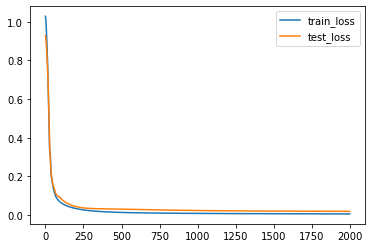

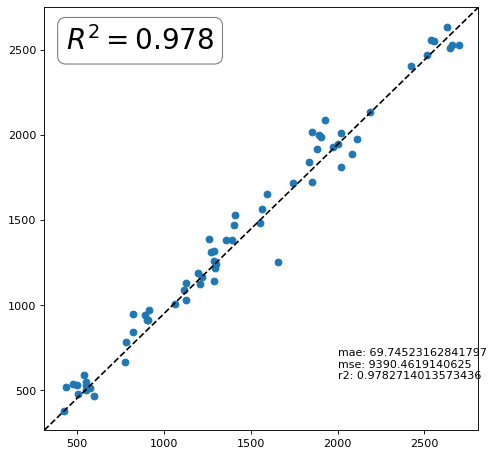

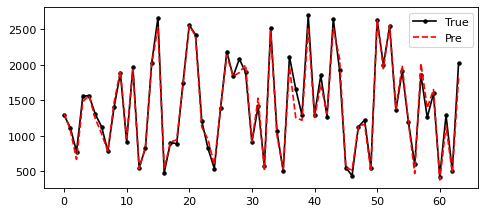

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from  torch import optim
import torchvision
import numpy as np
from scipy import io
from numpy import *
from matplotlib import pyplot as plt
import pandas as pd
np.random.seed(1)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import dd3
from dd3 import ddNet
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
class ddNet(nn.Module):

    def __init__(self):
        super(ddNet, self).__init__()

        # xw+b
        self.fc0 = nn.Linear(14, 200, bias=True)
        self.dd = nn.Linear(200, 200, bias=True)
        self.dd2 = nn.Linear(200, 200, bias=True)
        self.dd3 = nn.Linear(200, 200, bias=True)
        self.dd4 = nn.Linear(200, 200, bias=True)

        self.fc2 = nn.Linear(200, 1, bias=True)

    def forward(self, x):
        x = self.fc0(x)
        c = x
        x=self.dd(x)*c
        x=self.dd2(x)*c
        x=self.dd3(x)*c
        x=self.dd4(x) * c
        x = self.fc2(x)
        return x

filename = './dta厌氧工厂.csv'
data = pd.read_csv(filename,encoding='gbk')

features = [
            '水解pH',
            '水解VFA',
            '水解TS',
            '水解VS',
            '水解氨氮',
            '水解COD',
            '发酵pH',
            '发酵VFA',
            '发酵碱度',
            '发酵TS',
            '发酵VS',
            '发酵氨氮',
            '发酵COD',
            '进料量',
]
target = ['产气量']

x = np.array(data[features])
y = np.array(data[target]).reshape(-1,1)

###############################################################################
X_train, X_validation, Y_train, Y_validation = train_test_split(x, y,
                                                                test_size=0.2
                                                                )
trans_x = StandardScaler()
trans_y = StandardScaler()
x_train = trans_x.fit_transform(X_train)
y_train = trans_y.fit_transform(Y_train)
x_test = trans_x.transform(X_validation)
y_test = trans_y.transform(Y_validation)

###############################################################################

train_x = torch.from_numpy(x_train).float()
train_y = torch.from_numpy(y_train).float()
test_x = torch.from_numpy(x_test).float()
test_y = torch.from_numpy(y_test).float()

###############################################################################

n_input = train_x.shape[1]
n_output = train_y.shape[1]

net = ddNet()
loss = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.005,momentum=0.9)
num_epochs =2000


###############################################################################

def pre(x, y):
    net.eval()
    y_pre = net(x)
    return loss(y_pre, y)

###############################################################################

l_train = [0]*num_epochs
l_test = [0]*num_epochs
for epoch in range(num_epochs):
    net.train()
    l = loss(net(train_x),train_y)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    l_train[epoch] = l.detach().numpy()
    l_test[epoch] = pre(test_x, test_y).detach().numpy()
    print(f'\repoch {epoch + 1}, loss {l:f}', end='')
torch.save(net, 'ddnet_2.pkl')
###############################################################################
# net=torch.load('ddnet_2.pkl')#载入模型
plt.figure()
plt.plot(l_train, label='train_loss')
plt.plot(l_test, label='test_loss')
plt.legend(loc='upper right')
plt.show()

###############################################################################

net.eval()
pre_y = net(test_x).detach().numpy()
test_y = trans_y.inverse_transform(test_y)
pre_y = trans_y.inverse_transform(pre_y)
# print(pre_y)
# test_y = trans_y.inverse_transform(test_y)
# pre_y = trans_y.inverse_transform(pre_y)
mae = mean_absolute_error(test_y, pre_y)
mse = mean_squared_error(test_y, pre_y)
r2 = r2_score(test_y, pre_y)

result = '''
mae: {}
mse: {}
r2: {}
'''.format(mae, mse, r2)

fig, ax = plt.subplots(1, 1,figsize=(7,7),dpi=80)
plt.scatter(test_y, pre_y)
bbox = dict(boxstyle="round", fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.3f$' % (r2), 
         transform=ax.transAxes, size=25, bbox=bbox)
plt.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', label="1:1 line")
plt.text(2000,500,result)
plt.savefig('R2_2.jpg',dpi =100)
plt.show()

pre_y = net(test_x).detach().numpy()
pre_y = trans_y.inverse_transform(pre_y)
fig, ax = plt.subplots(1, 1,figsize=(7,3),dpi=80)
plt.plot(test_y,'k.-', label='True')
plt.plot(pre_y,'r--', label='Pre')
plt.legend(loc='upper right')
plt.savefig('TRUEvsPRE_2.jpg',dpi =100)
plt.show()